
# convex hull boundary intersection

Intersection boundary has 74 points.


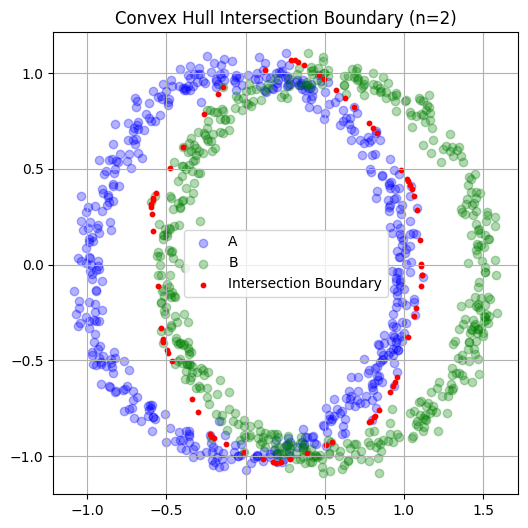

Intersection boundary has 453 points.


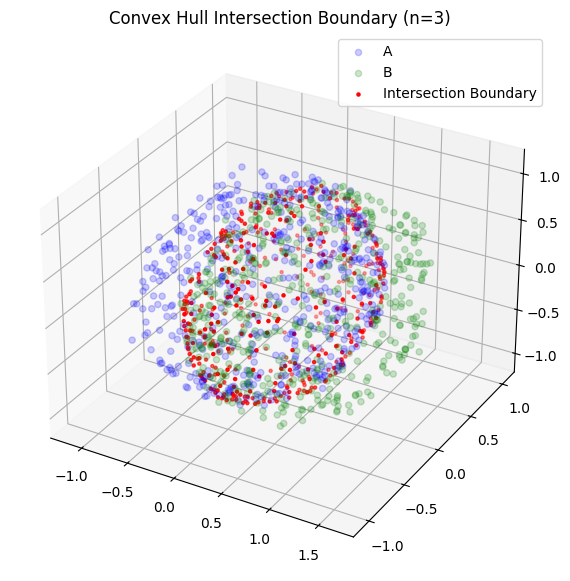

Intersection boundary has 988 points.


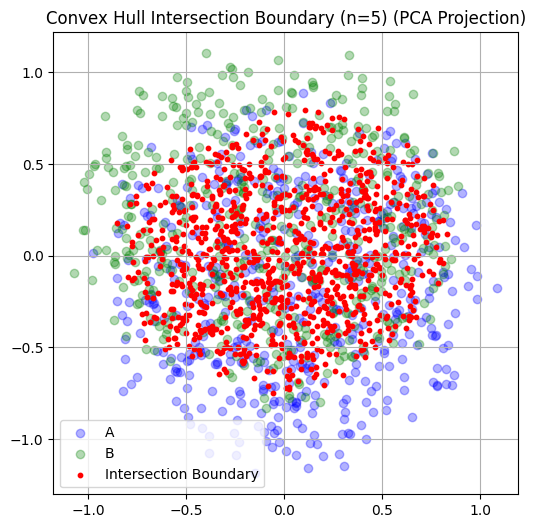

In [1]:
import numpy as np
from scipy.spatial import ConvexHull, Delaunay
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def is_in_hull(points, hull: ConvexHull):
    delaunay = Delaunay(hull.points[hull.vertices])
    return delaunay.find_simplex(points) >= 0

def sample_points(bounds, num=100000):
    dim = bounds.shape[0]
    return np.random.uniform(bounds[:, 0], bounds[:, 1], size=(num, dim))

def bounding_box(*arrays, pad=0.05):
    all_pts = np.vstack(arrays)
    mins = all_pts.min(axis=0)
    maxs = all_pts.max(axis=0)
    delta = (maxs - mins) * pad
    return np.stack([mins - delta, maxs + delta], axis=1)

def convex_hull_intersection_boundary(A, B, num_samples=100000):
    hull_A = ConvexHull(A)
    hull_B = ConvexHull(B)
    bounds = bounding_box(A, B)
    X = sample_points(bounds, num=num_samples)
    in_A = is_in_hull(X, hull_A)
    in_B = is_in_hull(X, hull_B)
    inter_pts = X[in_A & in_B]

    if len(inter_pts) < A.shape[1] + 1:
        print("Not enough points to define convex hull intersection.")
        return np.empty((0, A.shape[1])), hull_A, hull_B, None

    inter_hull = ConvexHull(inter_pts)
    boundary_pts = inter_hull.points[inter_hull.vertices]
    return boundary_pts, hull_A, hull_B, inter_hull

def generate_nd_ball(n, num_points=500, radius=1.0, noise=0.05, offset=None, seed=None):
    if seed is not None:
        np.random.seed(seed)
    points = np.random.normal(size=(num_points, n))
    points /= np.linalg.norm(points, axis=1, keepdims=True)
    points *= radius
    if offset is not None:
        points += offset
    return points + np.random.normal(scale=noise, size=points.shape)

def visualise_intersection(A, B, intersection_boundary, title="Convex Hull Intersection"):
    d = A.shape[1]
    if d == 2:
        plt.figure(figsize=(6, 6))
        plt.scatter(A[:,0], A[:,1], color='blue', alpha=0.3, label='A')
        plt.scatter(B[:,0], B[:,1], color='green', alpha=0.3, label='B')
        plt.scatter(intersection_boundary[:,0], intersection_boundary[:,1], color='red', s=10, label='Intersection Boundary')
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.show()

    elif d == 3:
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(A[:,0], A[:,1], A[:,2], color='blue', alpha=0.2, label='A')
        ax.scatter(B[:,0], B[:,1], B[:,2], color='green', alpha=0.2, label='B')
        ax.scatter(intersection_boundary[:,0], intersection_boundary[:,1], intersection_boundary[:,2], 
                   color='red', s=5, label='Intersection Boundary')
        ax.set_title(title)
        ax.legend()
        plt.show()

    else:
        all_data = np.vstack([A, B, intersection_boundary])
        pca = PCA(n_components=2)
        proj = pca.fit_transform(all_data)
        nA = len(A)
        nB = len(B)
        proj_A = proj[:nA]
        proj_B = proj[nA:nA+nB]
        proj_I = proj[nA+nB:]

        plt.figure(figsize=(6, 6))
        plt.scatter(proj_A[:,0], proj_A[:,1], color='blue', alpha=0.3, label='A')
        plt.scatter(proj_B[:,0], proj_B[:,1], color='green', alpha=0.3, label='B')
        plt.scatter(proj_I[:,0], proj_I[:,1], color='red', s=10, label='Intersection Boundary')
        plt.title(f"{title} (PCA Projection)")
        plt.legend()
        plt.grid(True)
        plt.show()

def main(n=5, points=500, offset_mag=0.5, samples=100000):
    A = generate_nd_ball(n, num_points=points, radius=1.0, seed=1)
    offset = np.zeros(n)
    offset[0] = offset_mag
    B = generate_nd_ball(n, num_points=points, radius=1.0, offset=offset, seed=2)

    boundary, hull_A, hull_B, hull_inter = convex_hull_intersection_boundary(A, B, num_samples=samples)
    print(f"Intersection boundary has {len(boundary)} points.")
    visualise_intersection(A, B, boundary, title=f"Convex Hull Intersection Boundary (n={n})")


main(n=2)   # Native 2D plot
main(n=3)   # Native 3D plot
main(n=5)   # PCA-projected 2D



=== Testing dimension: 1 ===
Intersection points found: 2


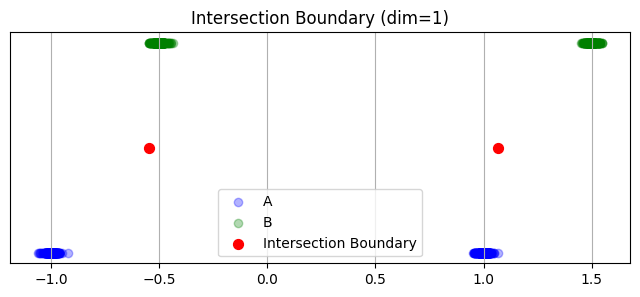


=== Testing dimension: 2 ===
Intersection points found: 53


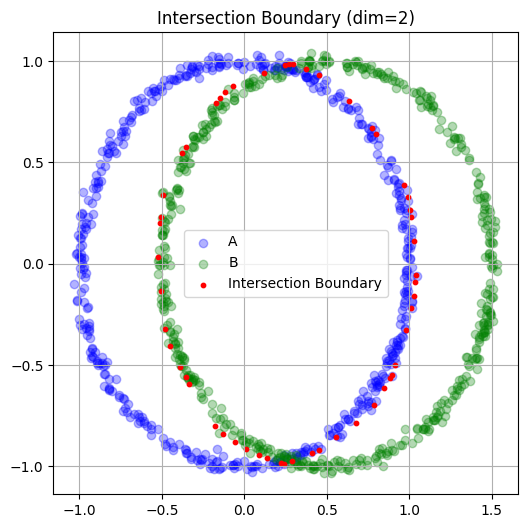


=== Testing dimension: 3 ===
Intersection points found: 259


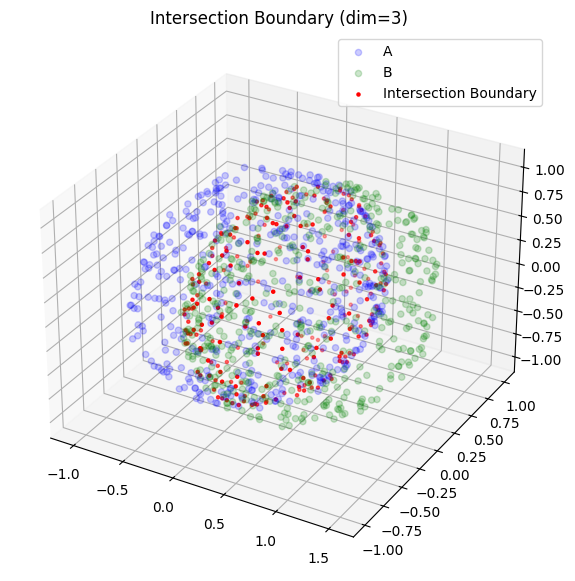


=== Testing dimension: 5 ===
Intersection points found: 580


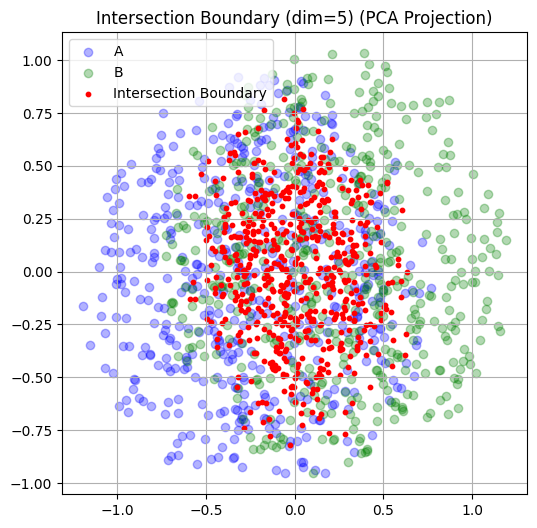


=== Testing dimension: 6 ===
Intersection points found: 175


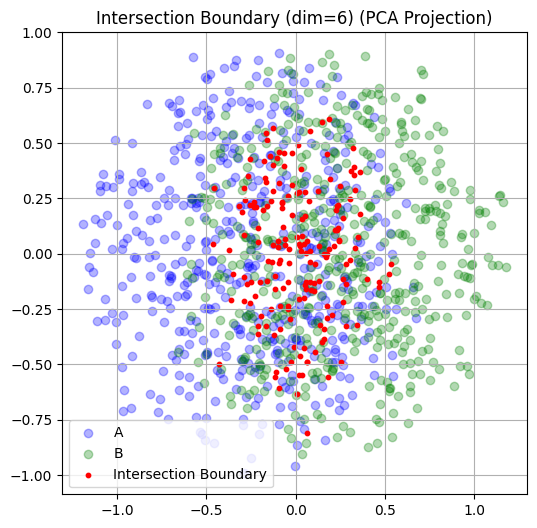

In [5]:
import numpy as np
from scipy.spatial import ConvexHull, Delaunay
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def is_in_hull(points, hull: ConvexHull):
    delaunay = Delaunay(hull.points[hull.vertices])
    return delaunay.find_simplex(points) >= 0

def sample_points(bounds, num=20000):
    dim = bounds.shape[0]
    return np.random.uniform(bounds[:, 0], bounds[:, 1], size=(num, dim))

def bounding_box(*arrays, pad=0.05):
    all_pts = np.vstack(arrays)
    mins = all_pts.min(axis=0)
    maxs = all_pts.max(axis=0)
    delta = (maxs - mins) * pad
    return np.stack([mins - delta, maxs + delta], axis=1)

def convex_hull_intersection_boundary(A, B, num_samples=20000):
    # Ensure inputs are 2D arrays (n_points, n_dims)
    if A.ndim == 1:
        A = A[:, np.newaxis]
    if B.ndim == 1:
        B = B[:, np.newaxis]

    dim = A.shape[1]

    if dim == 1:
        # 1D intersection: intervals overlap
        minA, maxA = np.min(A), np.max(A)
        minB, maxB = np.min(B), np.max(B)
        low = max(minA, minB)
        high = min(maxA, maxB)
        if high < low:
            # No intersection
            print("No intersection found in 1D.")
            return np.empty((0, 1)), None, None, None
        # Return boundary points of intersection interval
        boundary_pts = np.array([[low], [high]])
        return boundary_pts, None, None, None

    # For dim >= 2 do convex hull sampling-based intersection
    hull_A = ConvexHull(A)
    hull_B = ConvexHull(B)
    bounds = bounding_box(A, B)
    X = sample_points(bounds, num=num_samples)
    in_A = is_in_hull(X, hull_A)
    in_B = is_in_hull(X, hull_B)
    inter_pts = X[in_A & in_B]

    if len(inter_pts) == 0:
        print("No intersection points found.")
        return np.empty((0, dim)), hull_A, hull_B, None

    if dim <= 3 and len(inter_pts) >= dim + 1:
        inter_hull = ConvexHull(inter_pts)
        boundary_pts = inter_hull.points[inter_hull.vertices]
    else:
        boundary_pts = inter_pts

    return boundary_pts, hull_A, hull_B, None if dim > 3 else inter_hull

def generate_nd_ball(n, num_points=500, radius=1.0, noise=0.02, offset=None, seed=None):
    if seed is not None:
        np.random.seed(seed)
    points = np.random.normal(size=(num_points, n))
    points /= np.linalg.norm(points, axis=1, keepdims=True)
    points *= radius
    if offset is not None:
        points += offset
    points += np.random.normal(scale=noise, size=points.shape)
    if points.ndim == 1:
        points = points[:, np.newaxis]
    return points

def visualize_intersection(A, B, intersection_boundary, title="Intersection Boundary"):
    d = A.shape[1]
    if d == 1:
        plt.figure(figsize=(8, 3))
        plt.scatter(A[:, 0], np.zeros_like(A[:, 0]), color='blue', alpha=0.3, label='A')
        plt.scatter(B[:, 0], np.ones_like(B[:, 0]) * 0.1, color='green', alpha=0.3, label='B')
        plt.scatter(intersection_boundary[:, 0], np.ones_like(intersection_boundary[:, 0]) * 0.05,
                    color='red', s=50, label='Intersection Boundary')
        plt.title(title)
        plt.yticks([])
        plt.legend()
        plt.grid(True)
        plt.show()

    elif d == 2:
        plt.figure(figsize=(6, 6))
        plt.scatter(A[:, 0], A[:, 1], color='blue', alpha=0.3, label='A')
        plt.scatter(B[:, 0], B[:, 1], color='green', alpha=0.3, label='B')
        plt.scatter(intersection_boundary[:, 0], intersection_boundary[:, 1], color='red', s=10,
                    label='Intersection Boundary')
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.show()

    elif d == 3:
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(A[:, 0], A[:, 1], A[:, 2], color='blue', alpha=0.2, label='A')
        ax.scatter(B[:, 0], B[:, 1], B[:, 2], color='green', alpha=0.2, label='B')
        ax.scatter(intersection_boundary[:, 0], intersection_boundary[:, 1], intersection_boundary[:, 2], color='red',
                   s=5, label='Intersection Boundary')
        ax.set_title(title)
        ax.legend()
        plt.show()

    else:
        # >3D, show PCA 2D projection
        all_data = np.vstack([A, B, intersection_boundary])
        pca = PCA(n_components=2)
        proj = pca.fit_transform(all_data)
        nA = len(A)
        nB = len(B)
        proj_A = proj[:nA]
        proj_B = proj[nA:nA + nB]
        proj_I = proj[nA + nB:]

        plt.figure(figsize=(6, 6))
        plt.scatter(proj_A[:, 0], proj_A[:, 1], color='blue', alpha=0.3, label='A')
        plt.scatter(proj_B[:, 0], proj_B[:, 1], color='green', alpha=0.3, label='B')
        plt.scatter(proj_I[:, 0], proj_I[:, 1], color='red', s=10, label='Intersection Boundary')
        plt.title(f"{title} (PCA Projection)")
        plt.legend()
        plt.grid(True)
        plt.show()

def run_test_for_dim(dim):
    print(f"\n=== Testing dimension: {dim} ===")

    A = generate_nd_ball(dim, num_points=500, radius=1.0, seed=1)
    offset = np.zeros(dim)
    offset[0] = 0.5
    B = generate_nd_ball(dim, num_points=500, radius=1.0, offset=offset, seed=2)

    boundary_pts, hull_A, hull_B, hull_inter = convex_hull_intersection_boundary(A, B, num_samples=20000)
    print(f"Intersection points found: {len(boundary_pts)}")

    visualize_intersection(A, B, boundary_pts, title=f"Intersection Boundary (dim={dim})")

if __name__ == "__main__":
    for dim in [1, 2, 3, 5, 6]:
        run_test_for_dim(dim)


Benchmarking dim=1 for 10 runs...
Benchmarking dim=2 for 10 runs...
Benchmarking dim=3 for 10 runs...
Benchmarking dim=5 for 10 runs...
Benchmarking dim=6 for 10 runs...


C:\Users\mukul\AppData\Local\Temp\ipykernel_26372\3531197813.py:101: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_times, labels=[str(d) for d in dimensions])


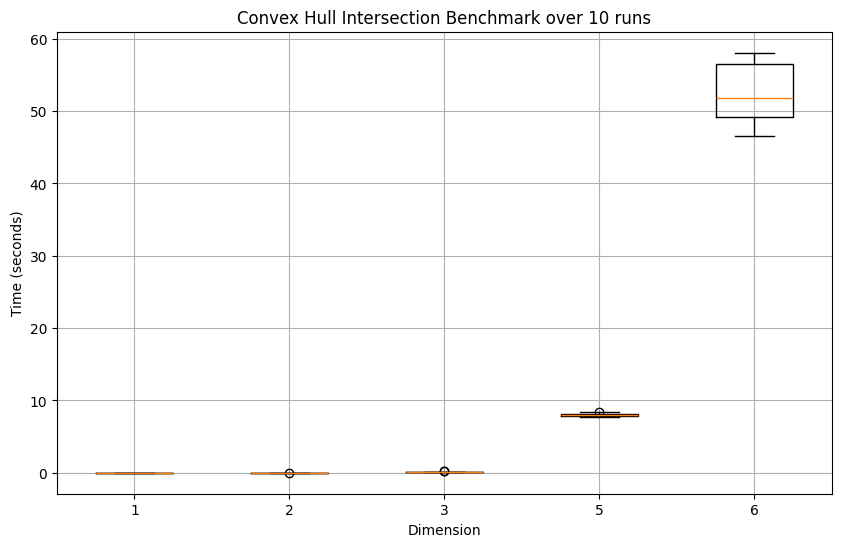

In [43]:
import numpy as np
from scipy.spatial import ConvexHull, Delaunay
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import time

def is_in_hull(points, hull: ConvexHull):
    delaunay = Delaunay(hull.points[hull.vertices])
    return delaunay.find_simplex(points) >= 0

def sample_points(bounds, num=20000):
    dim = bounds.shape[0]
    return np.random.uniform(bounds[:, 0], bounds[:, 1], size=(num, dim))

def bounding_box(*arrays, pad=0.05):
    all_pts = np.vstack(arrays)
    mins = all_pts.min(axis=0)
    maxs = all_pts.max(axis=0)
    delta = (maxs - mins) * pad
    return np.stack([mins - delta, maxs + delta], axis=1)

def convex_hull_intersection_boundary(A, B, num_samples=20000):
    if A.ndim == 1:
        A = A[:, np.newaxis]
    if B.ndim == 1:
        B = B[:, np.newaxis]

    dim = A.shape[1]

    if dim == 1:
        minA, maxA = np.min(A), np.max(A)
        minB, maxB = np.min(B), np.max(B)
        low = max(minA, minB)
        high = min(maxA, maxB)
        if high < low:
            return np.empty((0, 1)), None, None, None
        boundary_pts = np.array([[low], [high]])
        return boundary_pts, None, None, None

    hull_A = ConvexHull(A)
    hull_B = ConvexHull(B)
    bounds = bounding_box(A, B)
    X = sample_points(bounds, num=num_samples)
    in_A = is_in_hull(X, hull_A)
    in_B = is_in_hull(X, hull_B)
    inter_pts = X[in_A & in_B]

    if len(inter_pts) == 0:
        return np.empty((0, dim)), hull_A, hull_B, None

    if dim <= 3 and len(inter_pts) >= dim + 1:
        inter_hull = ConvexHull(inter_pts)
        boundary_pts = inter_hull.points[inter_hull.vertices]
    else:
        boundary_pts = inter_pts

    return boundary_pts, hull_A, hull_B, None if dim > 3 else inter_hull

def generate_nd_ball(n, num_points=500, radius=1.0, noise=0.02, offset=None, seed=None):
    if seed is not None:
        np.random.seed(seed)
    points = np.random.normal(size=(num_points, n))
    points /= np.linalg.norm(points, axis=1, keepdims=True)
    points *= radius
    if offset is not None:
        points += offset
    points += np.random.normal(scale=noise, size=points.shape)
    if points.ndim == 1:
        points = points[:, np.newaxis]
    return points

def run_test_for_dim(dim, num_samples=20000):
    A = generate_nd_ball(dim, num_points=500, radius=1.0, seed=1)
    offset = np.zeros(dim)
    offset[0] = 0.5
    B = generate_nd_ball(dim, num_points=500, radius=1.0, offset=offset, seed=2)
    boundary_pts, hull_A, hull_B, hull_inter = convex_hull_intersection_boundary(A, B, num_samples=num_samples)
    return len(boundary_pts)

def benchmark_intersection(dim, runs=10, num_samples=20000):
    times = []
    for _ in range(runs):
        A = generate_nd_ball(dim, num_points=500, radius=1.0, seed=None)
        offset = np.zeros(dim)
        offset[0] = 0.5
        B = generate_nd_ball(dim, num_points=500, radius=1.0, offset=offset, seed=None)
        start = time.time()
        convex_hull_intersection_boundary(A, B, num_samples=num_samples)
        end = time.time()
        times.append(end - start)
    return times

def plot_benchmarks(dimensions, runs=10):
    all_times = []
    for dim in dimensions:
        print(f"Benchmarking dim={dim} for {runs} runs...")
        times = benchmark_intersection(dim, runs=runs)
        all_times.append(times)
    
    plt.figure(figsize=(10, 6))
    plt.boxplot(all_times, labels=[str(d) for d in dimensions])
    plt.xlabel("Dimension")
    plt.ylabel("Time (seconds)")
    plt.title(f"Convex Hull Intersection Benchmark over {runs} runs")
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    dims = [1, 2, 3, 5, 6]
    plot_benchmarks(dims, runs=10)


Dimension 1 intersection points: 2


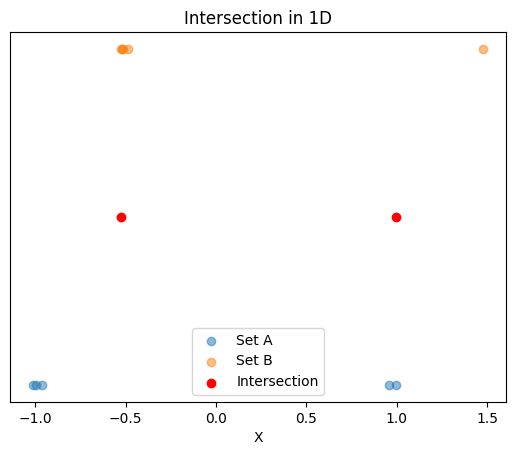

Dimension 2 intersection points: 59


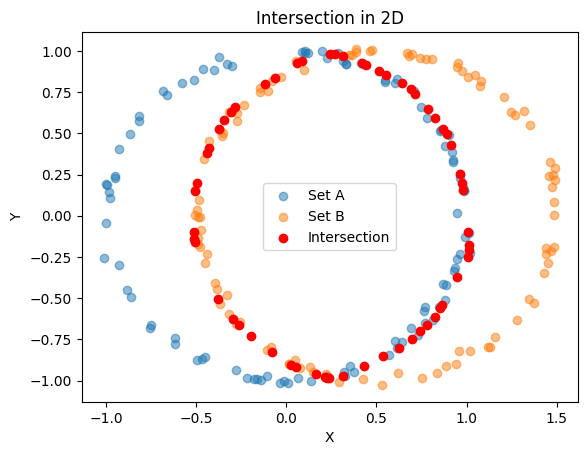

Dimension 3 intersection points: 259


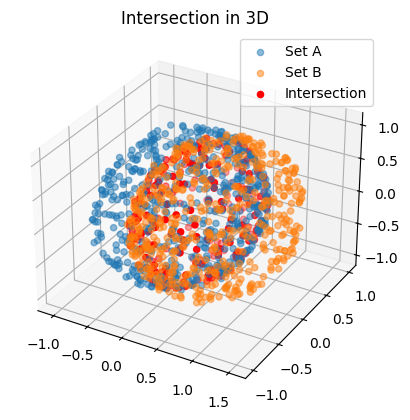

Dimension 5 intersection points: 695


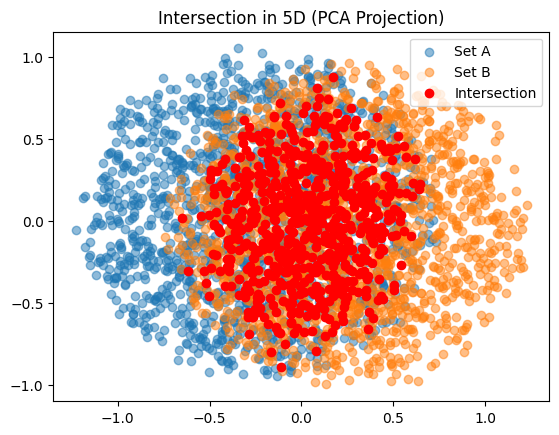

Dimension 6 intersection points: 274


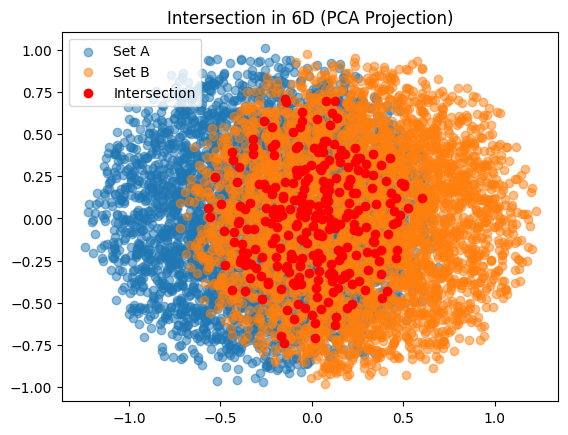

Benchmarking dim=1 (numba-accelerated) for 10 runs...
Benchmarking dim=2 (numba-accelerated) for 10 runs...
Benchmarking dim=3 (numba-accelerated) for 10 runs...
Benchmarking dim=5 (numba-accelerated) for 10 runs...
Benchmarking dim=6 (numba-accelerated) for 10 runs...


C:\Users\mukul\AppData\Local\Temp\ipykernel_22100\3964137878.py:174: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_times, labels=[str(d) for d in dims])


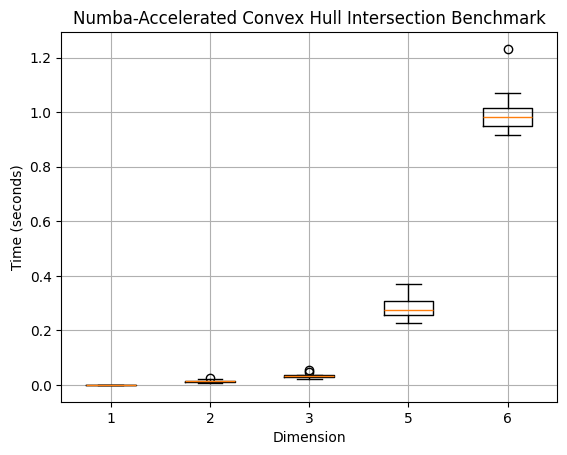

In [1]:
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import time
import numba
from sklearn.decomposition import PCA

@numba.njit
def point_in_hull_equations(points, equations):
    """
    points: (N,d)
    equations: (M,d+1) rows are [normal, offset]
    returns bool array of shape (N,)
    """
    N = points.shape[0]
    M = equations.shape[0]
    inside = np.ones(N, dtype=numba.boolean)
    for i in range(N):
        for j in range(M):
            # equation form: normal.dot(x) + offset <= 0 means inside halfspace
            val = 0.0
            for k in range(points.shape[1]):
                val += equations[j, k] * points[i, k]
            val += equations[j, -1]
            if val > 1e-12:  # allow some numerical tolerance
                inside[i] = False
                break
    return inside

def convex_hull_intersection_boundary_numba(A, B, num_samples=20000):
    if A.ndim == 1:
        A = A[:, np.newaxis]
    if B.ndim == 1:
        B = B[:, np.newaxis]
    dim = A.shape[1]

    if dim == 1:
        minA, maxA = np.min(A), np.max(A)
        minB, maxB = np.min(B), np.max(B)
        low = max(minA, minB)
        high = min(maxA, maxB)
        if high < low:
            return np.empty((0, 1)), None, None, None
        boundary_pts = np.array([[low], [high]])
        return boundary_pts, None, None, None

    hull_A = ConvexHull(A)
    hull_B = ConvexHull(B)
    bounds = bounding_box(A, B)
    X = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(num_samples, dim))

    # Use numba-accelerated point in hull test
    in_A = point_in_hull_equations(X, hull_A.equations)
    in_B = point_in_hull_equations(X, hull_B.equations)
    

    inter_pts = X[in_A & in_B]

    if len(inter_pts) == 0:
        return np.empty((0, dim)), hull_A, hull_B, None

    if dim <= 3 and len(inter_pts) >= dim + 1:
        inter_hull = ConvexHull(inter_pts)
        boundary_pts = inter_hull.points[inter_hull.vertices]
    else:
        boundary_pts = inter_pts

    return boundary_pts, hull_A, hull_B, None if dim > 3 else inter_hull


def visualize_intersection(A, B, intersection_pts, title="Intersection"):
    dim = A.shape[1] if A.ndim > 1 else 1
    
    if dim == 1:
        plt.figure()
        plt.scatter(A, np.zeros_like(A), label="Set A", alpha=0.5)
        plt.scatter(B, np.ones_like(B)*0.1, label="Set B", alpha=0.5)
        if len(intersection_pts) > 0:
            plt.scatter(intersection_pts, np.ones_like(intersection_pts)*0.05, color='red', label="Intersection")
        plt.legend()
        plt.title(title)
        plt.xlabel("X")
        plt.yticks([])
        plt.show()

    elif dim == 2:
        plt.figure()
        plt.scatter(A[:, 0], A[:, 1], label="Set A", alpha=0.5)
        plt.scatter(B[:, 0], B[:, 1], label="Set B", alpha=0.5)
        if len(intersection_pts) > 0:
            plt.scatter(intersection_pts[:, 0], intersection_pts[:, 1], color='red', label="Intersection")
        plt.legend()
        plt.title(title)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.show()

    elif dim == 3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(A[:, 0], A[:, 1], A[:, 2], label="Set A", alpha=0.5)
        ax.scatter(B[:, 0], B[:, 1], B[:, 2], label="Set B", alpha=0.5)
        if len(intersection_pts) > 0:
            ax.scatter(intersection_pts[:, 0], intersection_pts[:, 1], intersection_pts[:, 2], color='red', label="Intersection")
        ax.legend()
        ax.set_title(title)
        plt.show()

    else:
        pca = PCA(n_components=2)
        combined = np.vstack((A, B, intersection_pts))
        pca.fit(combined)
        A_p = pca.transform(A)
        B_p = pca.transform(B)
        inter_p = pca.transform(intersection_pts)
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(A_p[:, 0], A_p[:, 1], label="Set A", alpha=0.5)
        ax.scatter(B_p[:, 0], B_p[:, 1], label="Set B", alpha=0.5)
        if len(intersection_pts) > 0:
            ax.scatter(inter_p[:, 0], inter_p[:, 1], color='red', label="Intersection")
        ax.legend()
        ax.set_title(f"{title} (PCA Projection)")
        plt.show()


def bounding_box(*arrays, pad=0.05):
    all_pts = np.vstack(arrays)
    mins = all_pts.min(axis=0)
    maxs = all_pts.max(axis=0)
    delta = (maxs - mins) * pad
    return np.stack([mins - delta, maxs + delta], axis=1)

def generate_nd_ball(n, num_points=500, radius=1.0, noise=0.02, offset=None, seed=None):
    if seed is not None:
        np.random.seed(seed)
    points = np.random.normal(size=(num_points, n))
    points /= np.linalg.norm(points, axis=1, keepdims=True)
    points *= radius
    if offset is not None:
        points += offset
    points += np.random.normal(scale=noise, size=points.shape)
    if points.ndim == 1:
        points = points[:, np.newaxis]
    return points

# You can update your benchmark to use the new function

def benchmark_intersection_numba(dim, runs=10, num_samples=20000):
    times = []
    for _ in range(runs):
        A = generate_nd_ball(dim, num_points=500, radius=1.0, seed=None)
        offset = np.zeros(dim)
        offset[0] = 0.5
        B = generate_nd_ball(dim, num_points=500, radius=1.0, offset=offset, seed=None)
        start = time.time()
        convex_hull_intersection_boundary_numba(A, B, num_samples=num_samples)
        end = time.time()
        times.append(end - start)
    return times

def benchmarks():
    dims = [1, 2, 3, 5, 6]
    runs = 10

    import matplotlib.pyplot as plt
    all_times = []
    for dim in dims:
        print(f"Benchmarking dim={dim} (numba-accelerated) for {runs} runs...")
        times = benchmark_intersection_numba(dim, runs=runs)
        all_times.append(times)

    plt.boxplot(all_times, labels=[str(d) for d in dims])
    plt.xlabel("Dimension")
    plt.ylabel("Time (seconds)")
    plt.title("Numba-Accelerated Convex Hull Intersection Benchmark")
    plt.grid(True)
    plt.show()


def plots():
    dims = [1, 2, 3, 5, 6]
    points = [5, 100, 500, 1500, 4000]
    for dim, point in zip(dims, points):
        A = generate_nd_ball(dim, num_points=point, radius=1.0, seed=1)
        offset = np.zeros(dim)
        offset[0] = 0.5
        B = generate_nd_ball(dim, num_points=point, radius=1.0, offset=offset, seed=2)

        intersection_pts, _, _, _ = convex_hull_intersection_boundary_numba(A, B, num_samples=20000)

        print(f"Dimension {dim} intersection points: {len(intersection_pts)}")
        visualize_intersection(A, B, intersection_pts, title=f"Intersection in {dim}D")

plots()
benchmarks()

# baysiann kinda fusion 

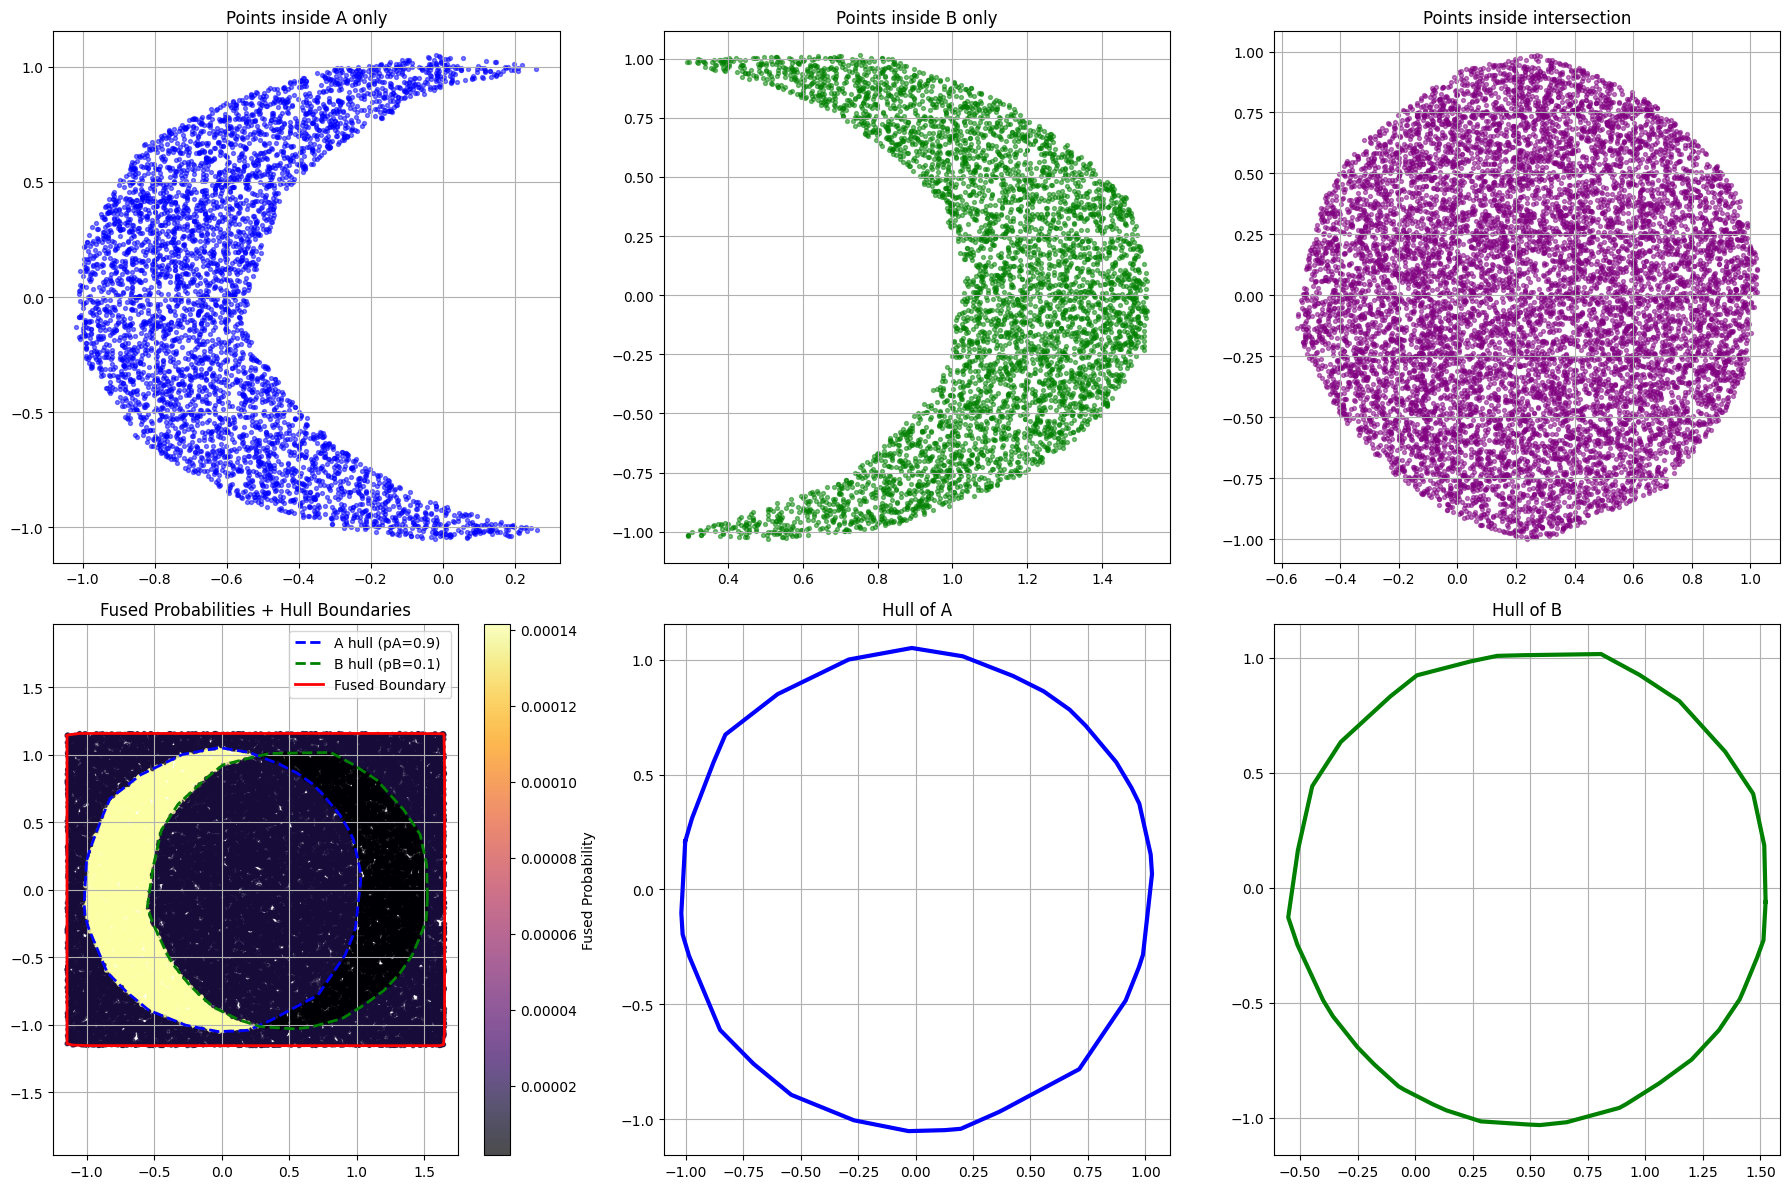

In [39]:
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import numba

PDF_FLOOR = 1e-10

@numba.njit
def point_in_hull_equations(points, equations):
    N = points.shape[0]
    inside = np.ones(N, dtype=numba.boolean)
    for i in range(N):
        for eq in equations:
            val = np.dot(eq[:-1], points[i]) + eq[-1]
            if val > 1e-12:
                inside[i] = False
                break
    return inside

def bounding_box(*arrays, pad=0.05):
    all_pts = np.vstack(arrays)
    mins = all_pts.min(axis=0)
    maxs = all_pts.max(axis=0)
    delta = (maxs - mins) * pad
    return np.stack([mins - delta, maxs + delta], axis=1)

def sample_points_in_bbox(bbox, num_samples=30000):
    dim = bbox.shape[0]
    samples = np.random.uniform(bbox[:, 0], bbox[:, 1], size=(num_samples, dim))
    return samples

def generate_nd_ball(n, num_points=500, radius=1.0, noise=0.02, offset=None, seed=None):
    if seed is not None:
        np.random.seed(seed)
    points = np.random.normal(size=(num_points, n))
    points /= np.linalg.norm(points, axis=1, keepdims=True)
    points *= radius
    if offset is not None:
        points += offset
    points += np.random.normal(scale=noise, size=points.shape)
    return points

def fuse_probabilities(pA_val, in_A, pB_val, in_B):
    # Assign p(x|A) and p(x|B) as pA or 1-pA depending on membership
    pA = np.where(in_A, pA_val, 1 - pA_val)
    pB = np.where(in_B, pB_val, 1 - pB_val)

    # Floor to avoid zeros
    pA = np.maximum(pA, PDF_FLOOR)
    pB = np.maximum(pB, PDF_FLOOR)

    # Fuse by multiplication and normalize
    fused = pA * pB
    fused /= fused.sum()

    return fused

def get_boundary_points(X, probabilities, threshold_ratio=0.01):
    max_prob = probabilities.max()
    threshold = threshold_ratio * max_prob
    selected_pts = X[probabilities >= threshold]
    if len(selected_pts) < 3:
        return np.empty((0, X.shape[1]))
    hull = ConvexHull(selected_pts)
    return selected_pts[hull.vertices]

def plot_all(X, in_A, in_B, A, B, hull_A, hull_B, pA_val, pB_val, pFused):
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    axs = axs.flatten()

    axs[0].scatter(X[in_A & ~in_B, 0], X[in_A & ~in_B, 1], s=8, color='blue', alpha=0.5)
    axs[0].set_title("Points inside A only")

    axs[1].scatter(X[in_B & ~in_A, 0], X[in_B & ~in_A, 1], s=8, color='green', alpha=0.5)
    axs[1].set_title("Points inside B only")

    axs[2].scatter(X[in_A & in_B, 0], X[in_A & in_B, 1], s=8, color='purple', alpha=0.5)
    axs[2].set_title("Points inside intersection")

    sc = axs[3].scatter(X[:, 0], X[:, 1], c=pFused, cmap='inferno', s=8, alpha=0.7)
    fig.colorbar(sc, ax=axs[3], label='Fused Probability')

    hull_A_pts = hull_A.points[hull_A.vertices]
    hull_A_closed = np.vstack([hull_A_pts, hull_A_pts[0]])
    axs[3].plot(hull_A_closed[:, 0], hull_A_closed[:, 1], 'b--', lw=2, label=f'A hull (pA={pA_val})')

    hull_B_pts = hull_B.points[hull_B.vertices]
    hull_B_closed = np.vstack([hull_B_pts, hull_B_pts[0]])
    axs[3].plot(hull_B_closed[:, 0], hull_B_closed[:, 1], 'g--', lw=2, label=f'B hull (pB={pB_val})')

    fused_boundary = get_boundary_points(X, pFused)
    if fused_boundary.size > 0:
        fused_boundary_closed = np.vstack([fused_boundary, fused_boundary[0]])
        axs[3].plot(fused_boundary_closed[:, 0], fused_boundary_closed[:, 1], 'r-', lw=2, label='Fused Boundary')

    axs[3].set_title("Fused Probabilities + Hull Boundaries")
    axs[3].legend()
    axs[3].axis('equal')

    axs[4].plot(hull_A_closed[:, 0], hull_A_closed[:, 1], 'b-', lw=3, label='A hull')
    axs[4].set_title("Hull of A")
    axs[4].axis('equal')

    axs[5].plot(hull_B_closed[:, 0], hull_B_closed[:, 1], 'g-', lw=3, label='B hull')
    axs[5].set_title("Hull of B")
    axs[5].axis('equal')

    for ax in axs:
        ax.grid(True)

    plt.tight_layout()
    plt.show()

def main():
    pA_val = 0.9
    pB_val = 0.1

    dim = 2
    A = generate_nd_ball(dim, num_points=500, radius=1.0, seed=42)
    B = generate_nd_ball(dim, num_points=500, radius=1.0, offset=np.array([0.5, 0.0]), seed=43)

    bbox = bounding_box(A, B)
    X = sample_points_in_bbox(bbox, num_samples=30000)

    hull_A = ConvexHull(A)
    hull_B = ConvexHull(B)

    in_A = point_in_hull_equations(X, hull_A.equations)
    in_B = point_in_hull_equations(X, hull_B.equations)

    pFused = fuse_probabilities(pA_val, in_A, pB_val, in_B)

    plot_all(X, in_A, in_B, A, B, hull_A, hull_B, pA_val, pB_val, pFused)

if __name__ == "__main__":
    main()


## combine two approaches

In [44]:
import sys
from pathlib import Path

# Get the current notebook's directory
parent = Path().resolve()  # Current working directory (notebook's directory)
root = parent.parent.parent       # Go one level up

print("Current Directory:", parent)
print("Parent Directory:", root)

# Optionally append to sys.path
sys.path.append(str(root))


Current Directory: D:\mukul\Desktop\Unimelb\Masters\Capstone\Learning-Dynamic-Systems\fusion\notebooks
Parent Directory: D:\mukul\Desktop\Unimelb\Masters\Capstone\Learning-Dynamic-Systems


Dimension 2 intersection points: 53


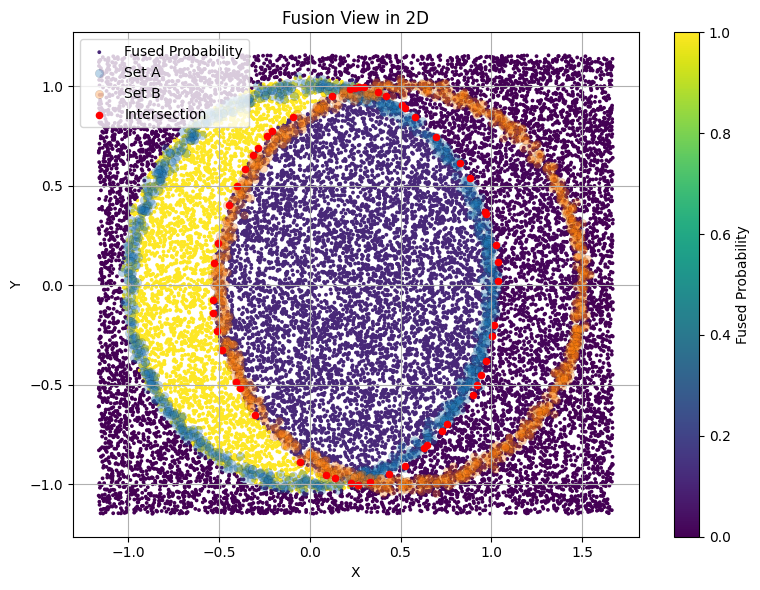

In [42]:
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import time
import numba
from fusion.fusion import construct_p_tensor, fuse, sample_fused_conf_region
import logging 

@numba.njit
def point_in_hull_equations(points, equations):
    """
    points: (N,d)
    equations: (M,d+1) rows are [normal, offset]
    returns bool array of shape (N,)
    """
    N = points.shape[0]
    M = equations.shape[0]
    inside = np.ones(N, dtype=numba.boolean)
    for i in range(N):
        for j in range(M):
            # equation form: normal.dot(x) + offset <= 0 means inside halfspace
            val = 0.0
            for k in range(points.shape[1]):
                val += equations[j, k] * points[i, k]
            val += equations[j, -1]
            if val > 1e-12:  # allow some numerical tolerance
                inside[i] = False
                break
    return inside


def sample_fused_conf_region(p_tensor, grid_axes, cumprob=0.95):
    """
    Find the confidence region for arbitrary-dimensional p_tensor using specified grid_axes.
    Returns selected points and actual cumulative probability achieved.
    
    Args:
        p_tensor: ndarray of probabilities (not necessarily 2D).
        grid_axes: list of arrays for each axis (e.g., [a_vals, b_vals, ...]).
        cumprob: desired cumulative probability (default: 0.95).
        
    Returns:
        selected_points: np.ndarray of shape (N, D), D = number of dimensions
        p: actual cumulative probability (float)
    """
    flat_p = p_tensor.flatten()
    sorted_indices = np.argsort(flat_p)[::-1]  # sort high to low
    sorted_probs = flat_p[sorted_indices]

    # Get unique candidate thresholds from highest to lowest
    candidate_thresholds = np.sort(np.unique(sorted_probs))[::-1]
    cumsums = []
    for threshold in candidate_thresholds:
        above_threshold = sorted_probs >= threshold
        cumsum = np.sum(sorted_probs[above_threshold])
        cumsums.append(cumsum)
    cumsums = np.array(cumsums)

    # Find threshold whose cumulative probability is closest to target
    idx = np.argmin(np.abs(cumsums - cumprob))
    if idx == len(cumsums) - 1:
        idx -= 1
    threshold = candidate_thresholds[idx]
    p = cumsums[idx]

    # Indices of elements in tensor above the threshold
    top_indices = np.where(sorted_probs >= threshold)[0]
    in_set_flat = sorted_indices[top_indices]
    unravelled = np.array(np.unravel_index(in_set_flat, p_tensor.shape)).T  # shape (N, D)

    # Map each index to its corresponding coordinate
    selected_points = np.stack(
        [grid_axes[d][unravelled[:, d]] for d in range(len(grid_axes))],
        axis=1
    )

    return selected_points, p
def fuse(new_info: np.ndarray, prior: np.ndarray, forget = 0.0):
    # https://en.wikipedia.org/wiki/Recursive_Bayesian_estimation#Model
    #  - not sure how to theoretically justify the forgetting factor part

    # forget: forgetting factor such that
    #   1 = disregard all past data
    #   0 = assume past data is always relevant (no change in plant over time)

    logger = logging.getLogger(__name__)
    if not 0.0 <= forget <= 1.0:
        forget = max(min(forget, 1), 0)
        logger.warning(f" Warning: invalid forget parameter (0 <= forget <= 1 not satisfied). Proceeding with forget={forget}.")
    
    modified_prior = np.mean(prior) * np.ones(prior.shape) * forget + prior * (1-forget)
    posterior = np.multiply(modified_prior, new_info) # Hadamard product
    posterior /= np.sum(np.abs(posterior)) # normalisation
    posterior = np.maximum(PDF_FLOOR, posterior) # to avoid floating point error, this is the new "zero" value
    return posterior

def construct_p_tensor(points_in_conf_region, grid_axes, p=0.95, eps=1e-6):
    """
    Constructs a PDF p_tensor over the grid defined by grid_axes.
    Gridpoints which are INSIDE or OUTSIDE the confidence region are set to have probability 'p' or '1-p' respectively.
    This is then normalised to form a PDF.

    Parameters:
    -----------
    points_in_conf_region : np.ndarray
        An array of shape (N, D) containing the D-dimensional grid points that lie within
        the confidence region (e.g., from sample_fused_rank_tensor()).
    grid_axes : list of np.ndarray
        A list of arrays representing the grid dimensions.
    p : float, optional
        Probability assigned to points in the confidence region (default is 0.95).
        All other points receive probability (1 - p).
    eps : float, optional
        Tolerance used in `np.isclose()` when checking if a grid point is in the confidence region.
        Default is 1e-6. Should be adjusted according to application specifics.

    Returns:
    --------
    np.ndarray
        A tensor of the same shape as the grid, containing normalized probabilities
        summing to 1 over the entire grid.
    """

    mesh = np.meshgrid(*grid_axes, indexing='ij')
    grid_shape = mesh[0].shape
    n_dims = len(grid_axes)

    # Initialize full p_tensor with p_bar = 1-p
    p_tensor = np.ones(grid_shape) * (1 - p)

    # Loop through all indices in the grid, amending p=0.95 for points in confidence region
    for idx in np.ndindex(grid_shape):
        pt = np.array([axis[idx] for axis in mesh])
        if np.any(np.all(np.isclose(points_in_conf_region, pt, atol=eps), axis=1)):
            p_tensor[idx] = p

    # Normalize
    p_tensor /= np.sum(np.abs(p_tensor))
    return p_tensor


def convex_hull_intersection_boundary_numba(A, B, num_samples=20000):
    if A.ndim == 1:
        A = A[:, np.newaxis]
    if B.ndim == 1:
        B = B[:, np.newaxis]
    dim = A.shape[1]

    if dim == 1:
        minA, maxA = np.min(A), np.max(A)
        minB, maxB = np.min(B), np.max(B)
        low = max(minA, minB)
        high = min(maxA, maxB)
        if high < low:
            return np.empty((0, 1)), None, None, None
        boundary_pts = np.array([[low], [high]])
        return boundary_pts, None, None, None

    hull_A = ConvexHull(A)
    hull_B = ConvexHull(B)
    bounds = bounding_box(A, B)
    X = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(num_samples, dim))

    # Use numba-accelerated point in hull test
    in_A = point_in_hull_equations(X, hull_A.equations)
    in_B = point_in_hull_equations(X, hull_B.equations)
    
   
    inter_pts = X[in_A & in_B]

    if len(inter_pts) == 0:
        return np.empty((0, dim)), hull_A, hull_B, None

    if dim <= 3 and len(inter_pts) >= dim + 1:
        inter_hull = ConvexHull(inter_pts)
        boundary_pts = inter_hull.points[inter_hull.vertices]
    else:
        boundary_pts = inter_pts

    return boundary_pts, hull_A, hull_B, None if dim > 3 else inter_hull


def visualize_intersection(A, B, intersection_pts, title="Intersection"):
    dim = A.shape[1] if A.ndim > 1 else 1
    
    if dim == 1:
        plt.figure()
        plt.scatter(A, np.zeros_like(A), label="Set A", alpha=0.5)
        plt.scatter(B, np.ones_like(B)*0.1, label="Set B", alpha=0.5)
        if len(intersection_pts) > 0:
            plt.scatter(intersection_pts, np.ones_like(intersection_pts)*0.05, color='red', label="Intersection")
        plt.legend()
        plt.title(title)
        plt.xlabel("X")
        plt.yticks([])
        plt.show()

    elif dim == 2:
        plt.figure()
        plt.scatter(A[:, 0], A[:, 1], label="Set A", alpha=0.5)
        plt.scatter(B[:, 0], B[:, 1], label="Set B", alpha=0.5)
        if len(intersection_pts) > 0:
            plt.scatter(intersection_pts[:, 0], intersection_pts[:, 1], color='red', label="Intersection")
        plt.legend()
        plt.title(title)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.show()

    elif dim == 3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(A[:, 0], A[:, 1], A[:, 2], label="Set A", alpha=0.5)
        ax.scatter(B[:, 0], B[:, 1], B[:, 2], label="Set B", alpha=0.5)
        if len(intersection_pts) > 0:
            ax.scatter(intersection_pts[:, 0], intersection_pts[:, 1], intersection_pts[:, 2], color='red', label="Intersection")
        ax.legend()
        ax.set_title(title)
        plt.show()

    else:
        pca = PCA(n_components=2)
        combined = np.vstack((A, B, intersection_pts))
        pca.fit(combined)
        A_p = pca.transform(A)
        B_p = pca.transform(B)
        inter_p = pca.transform(intersection_pts)
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(A_p[:, 0], A_p[:, 1], label="Set A", alpha=0.5)
        ax.scatter(B_p[:, 0], B_p[:, 1], label="Set B", alpha=0.5)
        if len(intersection_pts) > 0:
            ax.scatter(inter_p[:, 0], inter_p[:, 1], color='red', label="Intersection")
        ax.legend()
        ax.set_title(f"{title} (PCA Projection)")
        plt.show()


def bounding_box(*arrays, pad=0.05):
    all_pts = np.vstack(arrays)
    mins = all_pts.min(axis=0)
    maxs = all_pts.max(axis=0)
    delta = (maxs - mins) * pad
    return np.stack([mins - delta, maxs + delta], axis=1)

def generate_nd_ball(n, num_points=500, radius=1.0, noise=0.02, offset=None, seed=None):
    if seed is not None:
        np.random.seed(seed)
    points = np.random.normal(size=(num_points, n))
    points /= np.linalg.norm(points, axis=1, keepdims=True)
    points *= radius
    if offset is not None:
        points += offset
    points += np.random.normal(scale=noise, size=points.shape)
    if points.ndim == 1:
        points = points[:, np.newaxis]
    return points

# You can update your benchmark to use the new function

def benchmark_intersection_numba(dim, runs=10, num_samples=20000):
    times = []
    for _ in range(runs):
        A = generate_nd_ball(dim, num_points=500, radius=1.0, seed=None)
        offset = np.zeros(dim)
        offset[0] = 0.5
        B = generate_nd_ball(dim, num_points=500, radius=1.0, offset=offset, seed=None)
        start = time.time()
        convex_hull_intersection_boundary_numba(A, B, num_samples=num_samples)
        end = time.time()
        times.append(end - start)
    return times

def benchmarks():
    dims = [1, 2, 3, 5, 6]
    runs = 10

    import matplotlib.pyplot as plt
    all_times = []
    for dim in dims:
        print(f"Benchmarking dim={dim} (numba-accelerated) for {runs} runs...")
        times = benchmark_intersection_numba(dim, runs=runs)
        all_times.append(times)

    plt.boxplot(all_times, labels=[str(d) for d in dims])
    plt.xlabel("Dimension")
    plt.ylabel("Time (seconds)")
    plt.title("Numba-Accelerated Convex Hull Intersection Benchmark")
    plt.grid(True)
    plt.show()


def plots():
    dims = [1, 2, 3, 5, 6]
    points = [5, 100, 500, 1500, 4000]
    for dim, point in zip(dims, points):
        A = generate_nd_ball(dim, num_points=point, radius=1.0, seed=1)
        offset = np.zeros(dim)
        offset[0] = 0.5
        B = generate_nd_ball(dim, num_points=point, radius=1.0, offset=offset, seed=2)

        intersection_pts, _, _, _ = convex_hull_intersection_boundary_numba(A, B, num_samples=20000)

        print(f"Dimension {dim} intersection points: {len(intersection_pts)}")
        visualize_intersection(A, B, intersection_pts, title=f"Intersection in {dim}D")

plots()
benchmarks()

# combined

Dimension 1 intersection points: 2


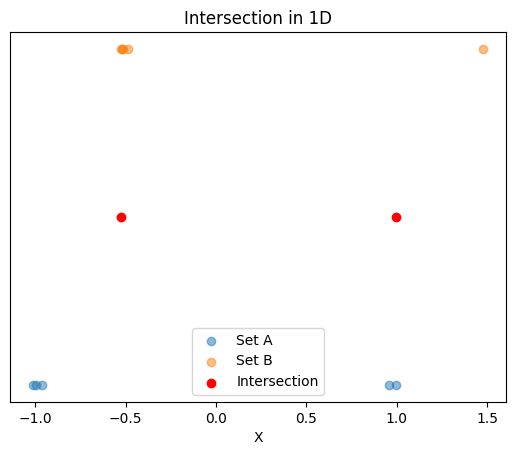

Dimension 2 intersection points: 25


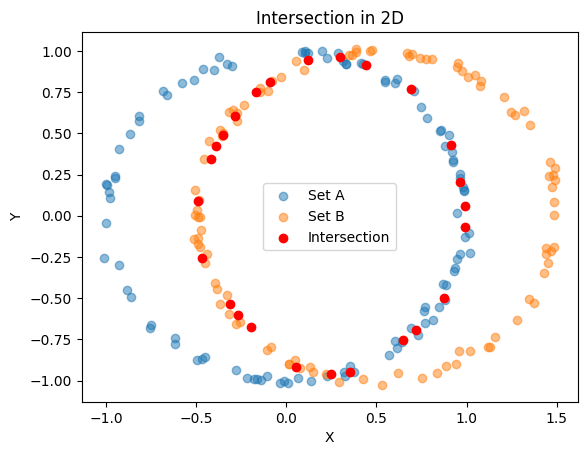

Dimension 3 intersection points: 143


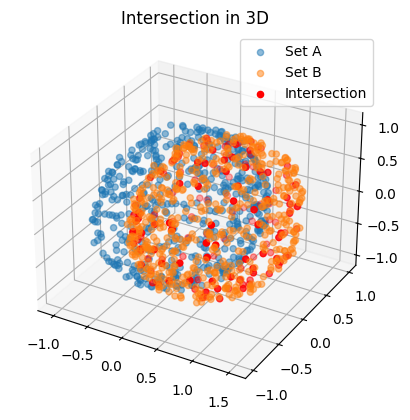

Dimension 5 intersection points: 4041


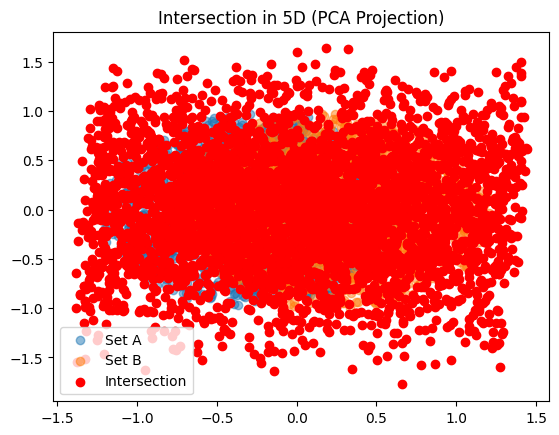

Dimension 6 intersection points: 27390


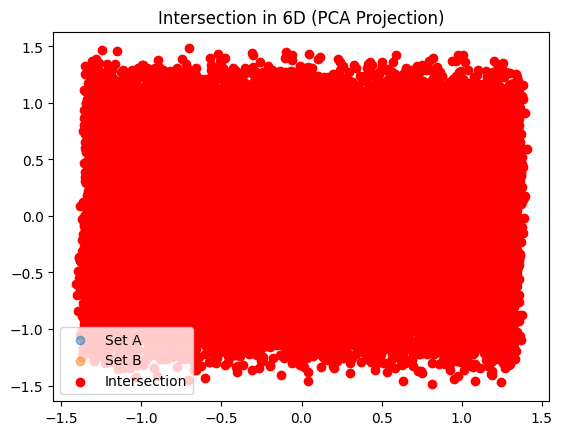

Benchmarking dim=1 (numba-accelerated) for 10 runs...
Benchmarking dim=2 (numba-accelerated) for 10 runs...
Benchmarking dim=3 (numba-accelerated) for 10 runs...
Benchmarking dim=5 (numba-accelerated) for 10 runs...
Benchmarking dim=6 (numba-accelerated) for 10 runs...


C:\Users\mukul\AppData\Local\Temp\ipykernel_22100\4052455838.py:311: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_times, labels=[str(d) for d in dims])


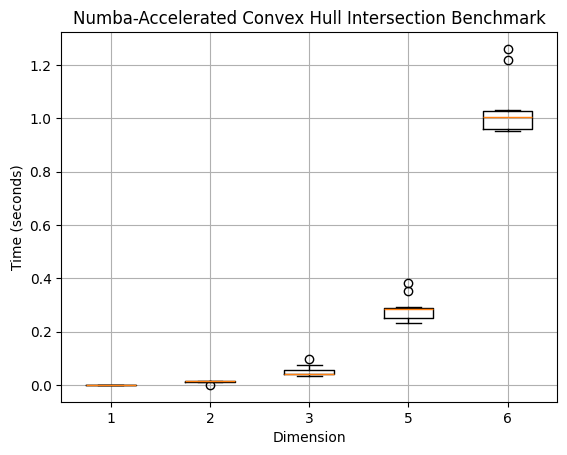

In [ ]:
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import time
import numba
from sklearn.decomposition import PCA

PDF_FLOOR = 1e-16   # to avoid numerical stability issues, this is the new "zero" value
@numba.njit
def fuse(new_info: np.ndarray, prior: np.ndarray, forget = 0.0):
    # https://en.wikipedia.org/wiki/Recursive_Bayesian_estimation#Model
    #  - not sure how to theoretically justify the forgetting factor part

    # forget: forgetting factor such that
    #   1 = disregard all past data
    #   0 = assume past data is always relevant (no change in plant over time)

    if not 0.0 <= forget <= 1.0:
        forget = max(min(forget, 1), 0)
        
    modified_prior = np.mean(prior) * np.ones(prior.shape) * forget + prior * (1-forget)
    posterior = np.multiply(modified_prior, new_info) # Hadamard product
    posterior /= np.sum(np.abs(posterior)) # normalisation
    posterior = np.maximum(PDF_FLOOR, posterior) # to avoid floating point error, this is the new "zero" value
    return posterior

@numba.njit
def point_in_hull_equations(points, equations):
    """
    points: (N,d)
    equations: (M,d+1) rows are [normal, offset]
    returns bool array of shape (N,)
    """
    N = points.shape[0]
    M = equations.shape[0]
    inside = np.ones(N, dtype=numba.boolean)
    for i in range(N):
        for j in range(M):
            # equation form: normal.dot(x) + offset <= 0 means inside halfspace
            val = 0.0
            for k in range(points.shape[1]):
                val += equations[j, k] * points[i, k]
            val += equations[j, -1]
            if val > 1e-12:  # allow some numerical tolerance
                inside[i] = False
                break
    return inside


@numba.njit
def point_in_hull_prob(points, equations, p):
    """
    points: (N, d)
    equations: (M, d+1), rows are [normal, offset]
    p: probability assigned to points inside the hull

    Returns:
        normalized_probs: (N,) np.ndarray of probabilities normalized to sum to 1
        inside: (N,) np.ndarray of bools for inside hull
    """
    N, d = points.shape
    M = equations.shape[0]
    inside = np.ones(N, dtype=numba.boolean)
    probs = np.empty(N, dtype=np.float64)

    for i in range(N):
        is_inside = True
        for j in range(M):
            val = 0.0
            for k in range(d):
                val += equations[j, k] * points[i, k]
            val += equations[j, -1]
            if val > 1e-12:
                is_inside = False
                break
        inside[i] = is_inside
        probs[i] = p if is_inside else (1.0 - p)

    prob_sum = np.sum(probs)
    if prob_sum > 0:
        probs /= prob_sum

    return probs, inside

def sample_conf_region_from_points(points: np.ndarray, probs: np.ndarray, cumprob: float = 0.95):
    """
    Select the most probable subset of points until the cumulative probability reaches `cumprob`.

    Args:
        points: ndarray of shape (N, D) — raw coordinates.
        probs: ndarray of shape (N,) — probabilities associated with each point.
        cumprob: float — desired cumulative probability (e.g., 0.95).

    Returns:
        selected_points: ndarray of shape (M, D) where M <= N
        actual_cumprob: float — cumulative probability of selected points
    """
    assert points.shape[0] == probs.shape[0], "Mismatch between number of points and probabilities"
    probs = probs / probs.sum()  # Ensure normalization

    # Sort probabilities descending
    sorted_indices = np.argsort(probs)[::-1]
    sorted_probs = probs[sorted_indices]
    sorted_points = points[sorted_indices]

    # Cumulative sum to determine cutoff
    cum_probs = np.cumsum(sorted_probs)
    cutoff_idx = np.searchsorted(cum_probs, cumprob, side='right')

    selected_points = sorted_points[:cutoff_idx + 1]
    actual_cumprob = cum_probs[cutoff_idx]

    return selected_points, actual_cumprob

def convex_hull_intersection_boundary_numba(A, B, num_samples=20000, p=0.95, forget=0.1):
    if A.ndim == 1:
        A = A[:, np.newaxis]
    if B.ndim == 1:
        B = B[:, np.newaxis]
    dim = A.shape[1]

    if dim == 1:
        minA, maxA = np.min(A), np.max(A)
        minB, maxB = np.min(B), np.max(B)
        low = max(minA, minB)
        high = min(maxA, maxB)
        if high < low:
            return np.empty((0, 1)), None, None, None
        boundary_pts = np.array([[low], [high]])
        return boundary_pts, None, None, None

    hull_A = ConvexHull(A)
    hull_B = ConvexHull(B)
    bounds = bounding_box(A, B)
    X = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(num_samples, dim))

    # Use numba-accelerated point in hull test
    p_A, in_A =  point_in_hull_prob(X, hull_A.equations, p)
    p_B, in_B = point_in_hull_prob(X, hull_B.equations, p)
    
    posterior = fuse(new_info=p_B, prior=p_A, forget=forget)
    inter_pts, achieved_prob = sample_conf_region_from_points(X, posterior, cumprob=p)
    # inter_pts = X[in_A & in_B]

    if len(inter_pts) == 0:
        return np.empty((0, dim)), hull_A, hull_B, None

    if dim <= 3 and len(inter_pts) >= dim + 1:
        inter_hull = ConvexHull(inter_pts)
        boundary_pts = inter_hull.points[inter_hull.vertices]
    else:
        boundary_pts = inter_pts
    # Plot fused posterior probabilities on the sample points
    # plot_fused_posterior(X, posterior, title=f"Fused Posterior Probabilities in {dim}D")
    return boundary_pts, hull_A, hull_B, None if dim > 3 else inter_hull


def plot_fused_posterior(samples: np.ndarray, posterior_probs: np.ndarray, title="Fused Posterior Probabilities"):
    """
    Plot fused posterior probabilities over sampled points.

    Args:
        samples: ndarray of shape (N, D), sampled points in D-dimensional space.
        posterior_probs: ndarray of shape (N,), fused posterior probabilities for each sample.
        title: str, title of the plot.
    """
    dim = samples.shape[1] if samples.ndim > 1 else 1

    if dim == 1:
        plt.figure(figsize=(6, 4))
        plt.scatter(samples, np.zeros_like(samples), c=posterior_probs, cmap='viridis', s=15)
        plt.colorbar(label='Fused Posterior Probability')
        plt.title(f"{title} (1D)")
        plt.yticks([])
        plt.xlabel("X")
        plt.show()

    elif dim == 2:
        plt.figure(figsize=(6, 6))
        plt.scatter(samples[:, 0], samples[:, 1], c=posterior_probs, cmap='viridis', s=10)
        plt.colorbar(label='Fused Posterior Probability')
        plt.title(f"{title} (2D)")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.show()

    elif dim == 3:
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        p = ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2], c=posterior_probs, cmap='viridis', s=10)
        fig.colorbar(p, ax=ax, label='Fused Posterior Probability')
        ax.set_title(f"{title} (3D)")
        plt.show()

    else:
        # For higher dimensions, use PCA to project down to 2D for visualization
        pca = PCA(n_components=2)
        proj = pca.fit_transform(samples)
        plt.figure(figsize=(6, 6))
        plt.scatter(proj[:, 0], proj[:, 1], c=posterior_probs, cmap='viridis', s=10)
        plt.colorbar(label='Fused Posterior Probability')
        plt.title(f"{title} (PCA Projection)")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.show()

def visualize_intersection(A, B, intersection_pts, title="Intersection"):
    dim = A.shape[1] if A.ndim > 1 else 1
    
    if dim == 1:
        plt.figure()
        plt.scatter(A, np.zeros_like(A), label="Set A", alpha=0.5)
        plt.scatter(B, np.ones_like(B)*0.1, label="Set B", alpha=0.5)
        if len(intersection_pts) > 0:
            plt.scatter(intersection_pts, np.ones_like(intersection_pts)*0.05, color='red', label="Intersection")
        plt.legend()
        plt.title(title)
        plt.xlabel("X")
        plt.yticks([])
        plt.show()

    elif dim == 2:
        plt.figure()
        plt.scatter(A[:, 0], A[:, 1], label="Set A", alpha=0.5)
        plt.scatter(B[:, 0], B[:, 1], label="Set B", alpha=0.5)
        if len(intersection_pts) > 0:
            plt.scatter(intersection_pts[:, 0], intersection_pts[:, 1], color='red', label="Intersection")
        plt.legend()
        plt.title(title)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.show()

    elif dim == 3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(A[:, 0], A[:, 1], A[:, 2], label="Set A", alpha=0.5)
        ax.scatter(B[:, 0], B[:, 1], B[:, 2], label="Set B", alpha=0.5)
        if len(intersection_pts) > 0:
            ax.scatter(intersection_pts[:, 0], intersection_pts[:, 1], intersection_pts[:, 2], color='red', label="Intersection")
        ax.legend()
        ax.set_title(title)
        plt.show()

    else:
        pca = PCA(n_components=2)
        combined = np.vstack((A, B, intersection_pts))
        pca.fit(combined)
        A_p = pca.transform(A)
        B_p = pca.transform(B)
        inter_p = pca.transform(intersection_pts)
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(A_p[:, 0], A_p[:, 1], label="Set A", alpha=0.5)
        ax.scatter(B_p[:, 0], B_p[:, 1], label="Set B", alpha=0.5)
        if len(intersection_pts) > 0:
            ax.scatter(inter_p[:, 0], inter_p[:, 1], color='red', label="Intersection")
        ax.legend()
        ax.set_title(f"{title} (PCA Projection)")
        plt.show()


def bounding_box(*arrays, pad=0.05):
    all_pts = np.vstack(arrays)
    mins = all_pts.min(axis=0)
    maxs = all_pts.max(axis=0)
    delta = (maxs - mins) * pad
    return np.stack([mins - delta, maxs + delta], axis=1)

def generate_nd_ball(n, num_points=500, radius=1.0, noise=0.02, offset=None, seed=None):
    if seed is not None:
        np.random.seed(seed)
    points = np.random.normal(size=(num_points, n))
    points /= np.linalg.norm(points, axis=1, keepdims=True)
    points *= radius
    if offset is not None:
        points += offset
    points += np.random.normal(scale=noise, size=points.shape)
    if points.ndim == 1:
        points = points[:, np.newaxis]
    return points

# You can update your benchmark to use the new function

def benchmark_intersection_numba(dim, runs=10, num_samples=20000):
    times = []
    for _ in range(runs):
        A = generate_nd_ball(dim, num_points=500, radius=1.0, seed=None)
        offset = np.zeros(dim)
        offset[0] = 0.5
        B = generate_nd_ball(dim, num_points=500, radius=1.0, offset=offset, seed=None)
        start = time.time()
        convex_hull_intersection_boundary_numba(A, B, num_samples=num_samples)
        end = time.time()
        times.append(end - start)
    return times

def benchmarks():
    dims = [1, 2, 3, 5, 6]
    runs = 10

    import matplotlib.pyplot as plt
    all_times = []
    for dim in dims:
        print(f"Benchmarking dim={dim} (numba-accelerated) for {runs} runs...")
        times = benchmark_intersection_numba(dim, runs=runs)
        all_times.append(times)

    plt.boxplot(all_times, labels=[str(d) for d in dims])
    plt.xlabel("Dimension")
    plt.ylabel("Time (seconds)")
    plt.title("Numba-Accelerated Convex Hull Intersection Benchmark")
    plt.grid(True)
    plt.show()


def plots():
    dims = [1, 2, 3, 5, 6]
    points = [5, 100, 500, 1500, 4000]
    for dim, point in zip(dims, points):
        A = generate_nd_ball(dim, num_points=point, radius=1.0, seed=1)
        offset = np.zeros(dim)
        offset[0] = 0.5
        B = generate_nd_ball(dim, num_points=point, radius=1.0, offset=offset, seed=2)

        intersection_pts, _, _, _ = convex_hull_intersection_boundary_numba(A, B, num_samples=point*10, forget=0.01)

        print(f"Dimension {dim} intersection points: {len(intersection_pts)}")
        visualize_intersection(A, B, intersection_pts, title=f"Intersection in {dim}D")

plots()
benchmarks()

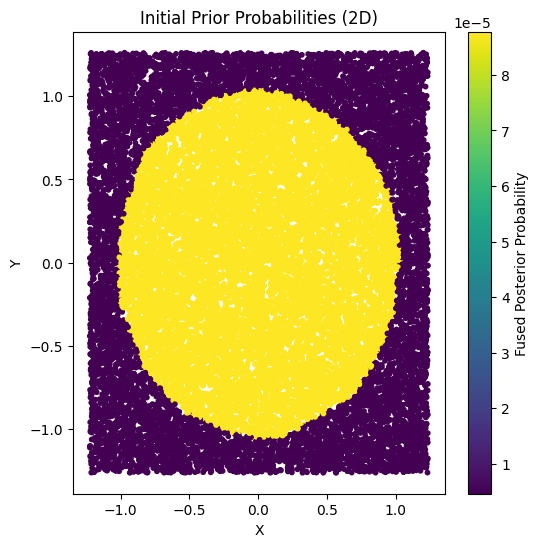

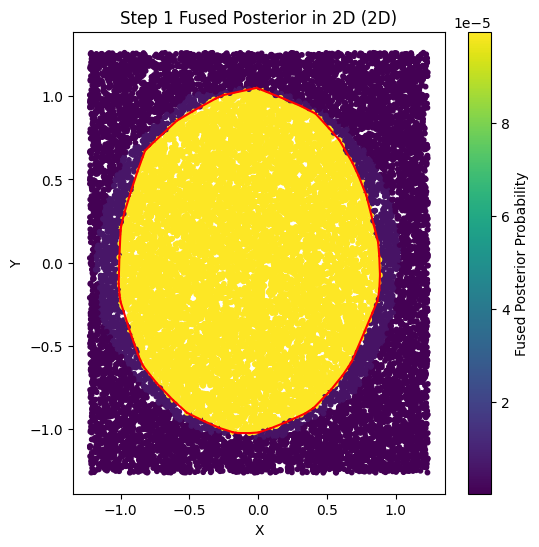

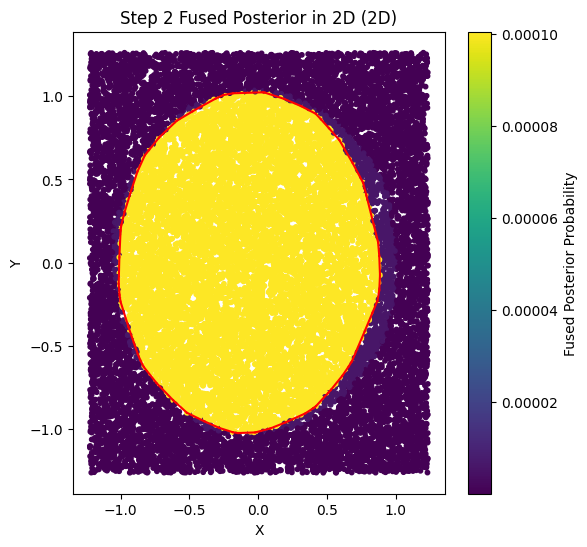

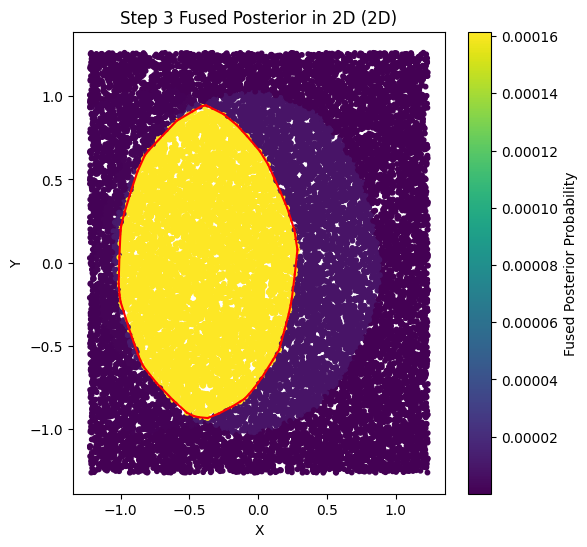

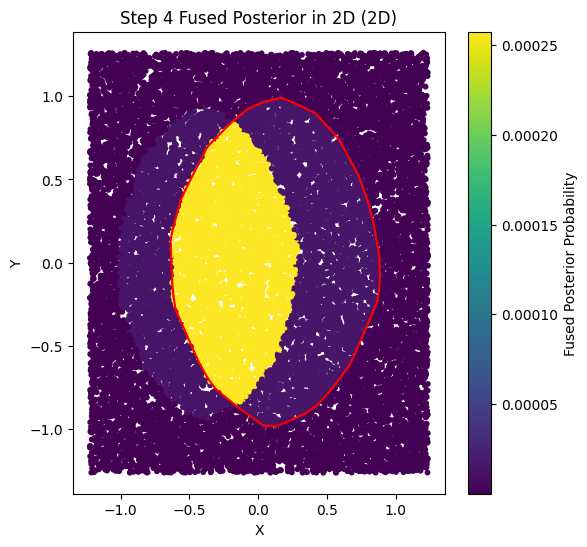

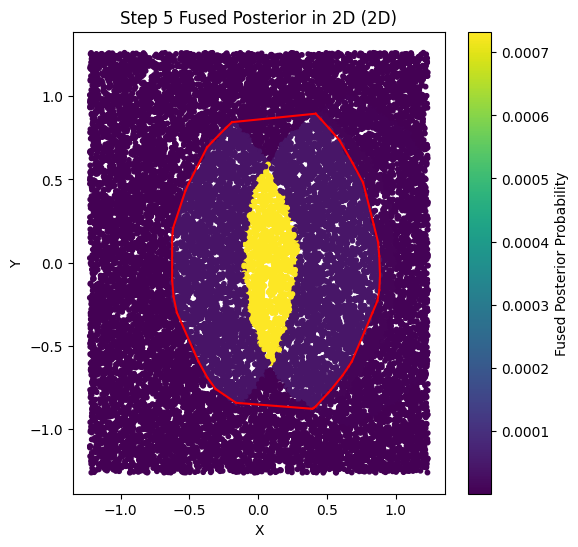

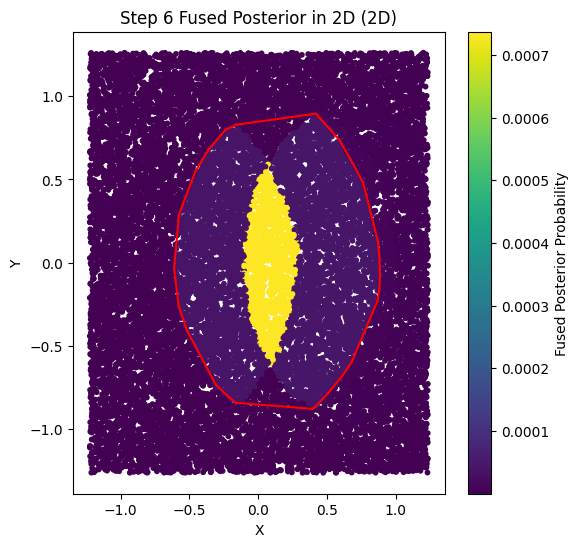

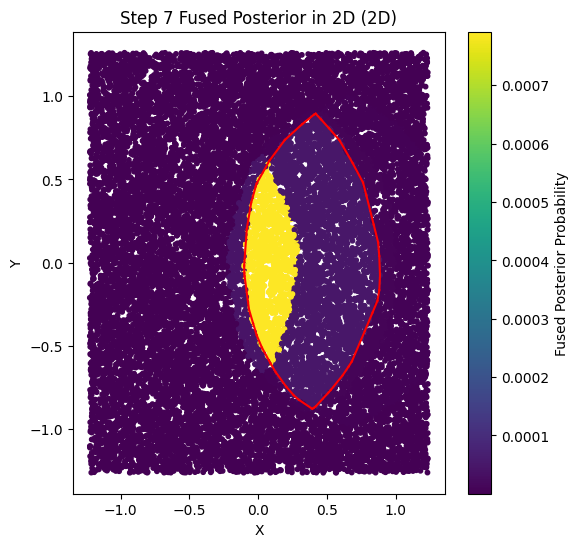

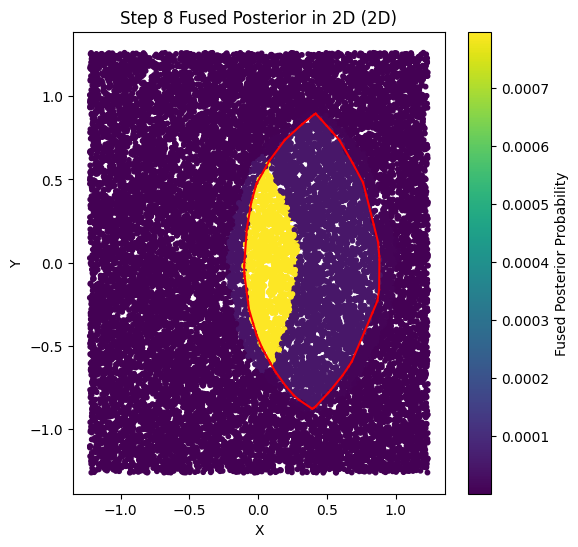

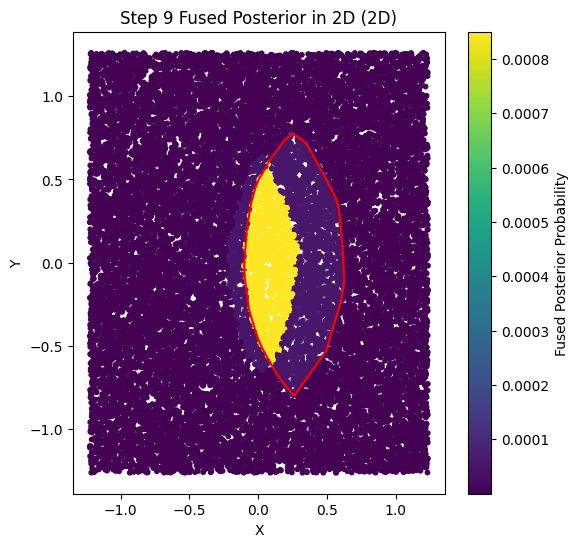

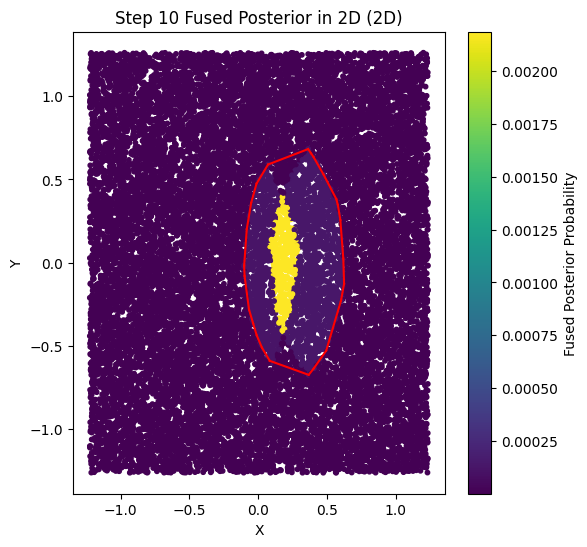

Incremental fusion with prior probability initialization complete.


In [54]:
def merge_bounding_boxes(bounds1: np.ndarray, bounds2: np.ndarray) -> np.ndarray:
    """
    Merge two bounding boxes to get a bounding box that covers both.

    Args:
        bounds1: ndarray of shape (dim, 2), bounding box 1 [min, max] per dimension
        bounds2: ndarray of shape (dim, 2), bounding box 2 [min, max] per dimension

    Returns:
        merged_bounds: ndarray of shape (dim, 2), bounding box covering both inputs
    """
    merged_bounds = np.empty_like(bounds1)
    merged_bounds[:, 0] = np.minimum(bounds1[:, 0], bounds2[:, 0])
    merged_bounds[:, 1] = np.maximum(bounds1[:, 1], bounds2[:, 1])
    return merged_bounds
def inflated_bounding_box(points, pad=0.1):
    """
    Compute bounding box around `points` and inflate it by a fraction `pad`.
    Returns array of shape (dim, 2) where each row is [min, max] per dimension.
    """
    mins = np.min(points, axis=0)
    maxs = np.max(points, axis=0)
    delta = (maxs - mins) * pad
    bounds = np.stack([mins - delta, maxs + delta], axis=1)
    return bounds

def plot_fused_posterior(samples: np.ndarray, posterior_probs: np.ndarray, title="Fused Posterior Probabilities", hull = None):
    """
    Plot fused posterior probabilities over sampled points and overlay a given convex hull.

    Args:
        samples: ndarray of shape (N, D), sampled points in D-dimensional space.
        posterior_probs: ndarray of shape (N,), fused posterior probabilities for each sample.
        title: str, title of the plot.
        hull: scipy.spatial.ConvexHull, convex hull to overlay (should match sample dimensionality).
    """
    dim = samples.shape[1] if samples.ndim > 1 else 1

    if dim == 1:
        plt.figure(figsize=(6, 4))
        plt.scatter(samples, np.zeros_like(samples), c=posterior_probs, cmap='viridis', s=15)
        plt.colorbar(label='Fused Posterior Probability')
        plt.title(f"{title} (1D)")
        plt.yticks([])
        plt.xlabel("X")
        plt.show()

    elif dim == 2:
        plt.figure(figsize=(6, 6))
        plt.scatter(samples[:, 0], samples[:, 1], c=posterior_probs, cmap='viridis', s=10)

        if hull is not None:
            for simplex in hull.simplices:
                plt.plot(hull.points[simplex, 0], hull.points[simplex, 1], 'r-', linewidth=1.5)

        plt.colorbar(label='Fused Posterior Probability')
        plt.title(f"{title} (2D)")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.show()

    elif dim == 3:
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        p = ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2], c=posterior_probs, cmap='viridis', s=10)

        if hull is not None:
            for simplex in hull.simplices:
                pts = hull.points[simplex]
                ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], 'r-', alpha=0.7)

        fig.colorbar(p, ax=ax, label='Fused Posterior Probability')
        ax.set_title(f"{title} (3D)")
        plt.show()

    else:
        pca = PCA(n_components=2)
        proj = pca.fit_transform(samples)
        plt.figure(figsize=(6, 6))
        plt.scatter(proj[:, 0], proj[:, 1], c=posterior_probs, cmap='viridis', s=10)

        if hull is not None:
            proj_hull = pca.transform(hull.points)
            for simplex in hull.simplices:
                plt.plot(proj_hull[simplex, 0], proj_hull[simplex, 1], 'r-')

        plt.colorbar(label='Fused Posterior Probability')
        plt.title(f"{title} (PCA Projection)")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.show()


def incremental_fusion_with_prior_prob(dim=3, num_points=500, num_steps=5, num_samples=20000, forget=0.01, p=0.95):
    # Generate initial region A as prior
    A = generate_nd_ball(dim, num_points=num_points, radius=1.0, seed=42)
    hull_A = ConvexHull(A)

    bounds = inflated_bounding_box(A, pad=0.1)
    X = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(num_samples, dim))

    # Initialize prior probabilities: assign p=0.95 inside hull_A, low outside
    p_A, in_A = point_in_hull_prob(X, hull_A.equations, p=p)
    prior_probs = p_A

    plot_fused_posterior(X, prior_probs, title="Initial Prior Probabilities")
    
    for step in range(num_steps):
        # Generate new info B with offset increasing each step
        offset = np.zeros(dim)
        offset[0] = np.random.normal(0, scale=0.5)
        B = generate_nd_ball(dim, num_points=num_points, radius=1.0, offset=offset, seed=100 + step)
        hull_B = ConvexHull(B)

        # Compute new info probabilities on X
        p_B, in_B = point_in_hull_prob(X, hull_B.equations, p=p)

        # Fuse prior and new info probabilities
        posterior = fuse(new_info=p_B, prior=prior_probs, forget=forget)

        # Sample the top points that capture cumulative probability (e.g., 95%)
        selected_pts, _ = sample_conf_region_from_points(X, posterior, cumprob=p)

        # Update prior points and prior_probs for next iteration
        new_hull = ConvexHull(selected_pts)

        prior_probs = posterior
        plot_fused_posterior(X, prior_probs, hull=new_hull, title=f"Step {step + 1} Fused Posterior in {dim}D")

    print("Incremental fusion with prior probability initialization complete.")


incremental_fusion_with_prior_prob(dim=2, num_steps=10)